# Survival Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.plotting import qq_plot, plot_interval_censored_lifetimes
import lifelines as lfl

## SEER dataset
> https://seer.cancer.gov/data-software/documentation/seerstat/nov2016/TextData.FileDescription.pdf

> https://arxiv.org/abs/2204.07276

- `id`: parient's ID
- `tte`: time to event
- `label`: cancer or not
- `AGE_DX`: patient's age
- `EOD10_SZ`: size of the tumor
- `MALIGCOUNT`: number of In Situ/malignant tumors for patient
- `BENBORDCOUNT`: number of benign/borderline tumors

## Data preparation

In [2]:
df = pd.read_csv('SEER_sample_imputed.csv')

# keeping just a few columns
df = df[['id', 'tte', 'label', 'AGE_DX', 'EOD10_SZ', 'MALIGCOUNT', 'BENBORDCOUNT']]

df = df.dropna()

# there are some 'id's duplicated
df.drop_duplicates('id', inplace=True)
df.set_index('id', inplace=True)

df = df.astype({'tte': int, 'label': int})

In [3]:
df.head()

,tte,label,AGE_DX,EOD10_SZ,MALIGCOUNT,BENBORDCOUNT
id,,,,,,
40003996,40,0,0.336449,0.04536,0.090909,0.0
38375019,2,1,0.598131,0.03006,0.000000,0.0
36142366,119,1,0.710280,0.04008,0.000000,0.0
35021855,229,1,0.560748,0.02004,0.000000,0.0
38377976,122,0,0.448598,0.06012,0.000000,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9966 entries, 40003996 to 38818610
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tte           9966 non-null   int32  
 1   label         9966 non-null   int32  
 2   AGE_DX        9966 non-null   float64
 3   EOD10_SZ      9966 non-null   float64
 4   MALIGCOUNT    9966 non-null   float64
 5   BENBORDCOUNT  9966 non-null   float64
dtypes: float64(4), int32(2)
memory usage: 467.2 KB


In [5]:
df.groupby(['label']).count()

,tte,AGE_DX,EOD10_SZ,MALIGCOUNT,BENBORDCOUNT
label,,,,,
0,6633,6633,6633,6633,6633
1,3333,3333,3333,3333,3333


### Censorhip

Happens when the **time to event** is partially known.

- **Not censored**: the event occured and the time is known.
- **Right-censored**: the survival duration is > the the observed. 
- **Left-censored**: the survival duration is < then the observed duration.
- **Interval-censored**: the survival duration is within the range but not exactly known.

> The data is **right-censored** because there are over 6,000 observations where the event didn't happen. It the cabe confirmed in the plot below.

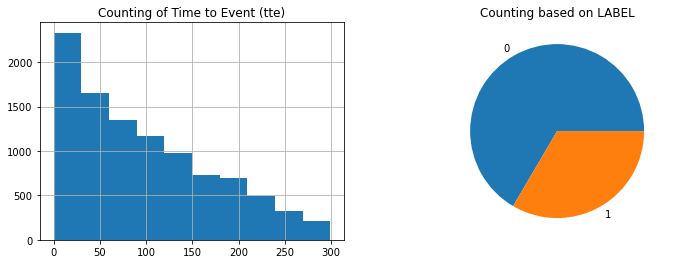

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Counting of Time to Event (tte)')
df['tte'].hist()

plt.subplot(1,2,2)
plt.title('Counting based on LABEL')
df.groupby(['label']).count()['tte'].plot(kind='pie', label='');

## Survival Function

- Shows the percentage of the population that **did not** experienced the event until that time $t$.
- Shows the **survival probability** (probability of the event of interest happens) after time $t$: 

$$\Large S(t) = Pr(T > t)$$

- $T$: when the event occurs.
- $t$: any point in time during an observation.


## Hazard Function

- Shows the probability of that event happens at some time give the survival up to that time.

$$\Large h(t) = -\frac{d}{dt} \log(S(t))$$

- **Hazard rate**: instantaneous rate of the event occuring

## Survival Function/Curve Estimation

$$\Large S(t) = \prod_{i:t_i \leq t} \left(1 - \frac{d_i}{n_i} \right)$$

- $t_i$: duration time
- $d_i$: number of events that happened at time $t_i$
- $n_i$: number of individuals known to have survived up to time $t_i$

### Non-parametric

- Does not assume underlying distribution.
- Describes the data better.
- It is not smooth/differentiable

#### Kaplan-Meier Model
most used

In [7]:
kmf = lfl.KaplanMeierFitter()
kmf.fit(durations=df['tte'], event_observed=df['label'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 9966 total observations, 6633 right-censored observations>

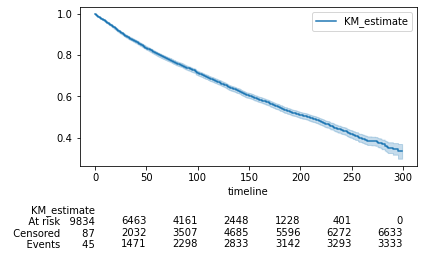

In [8]:
kmf.plot_survival_function(at_risk_counts=True)
plt.ylabel('Survival Probability');

In [9]:
# this measure might be wrong because more than 50% of the data is censored
print('Median survival time:', kmf.median_survival_time_)

Median survival time: 208.0


### Parametric 

- Usually gives more information because there is an underlying distribution
- Is necessary to assess the goodness-of-fit to avoid biases and misinterpretations


#### Weibull Model

$$\Large f(x; \lambda,k) = \frac{k}{\lambda} \left( \frac{x}{\lambda} \right)^{k-1} e^{-(x/\lambda)^k} \qquad \longrightarrow \quad S(t) = e^{-(t/\lambda)^\rho}$$

$$x \geq 0, k > 0, \lambda > 0$$

- $k$ or $\rho$: shape of the distribution
    - $k < 1$: event rate decreases over time
    - $k = 1$: event rate is constant
    - $k > 1$: event rate increases over time
    
- $\lambda$: scale of the distribution (indicates when 63.2% of the population has experienced the event)

In [10]:
wb = lfl.WeibullFitter()

# Weibull needs non-zero tte
df['tte'] = df['tte'] + 1e-10

wb.fit(durations=df['tte'], event_observed=df['label'])

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 9966 total observations, 6633 right-censored observations>

Lambda: 358.7938759636887
Rho: 0.7952285765619703


Text(0.5, 1.0, 'Survival function of Weibull model / estimated parameters')

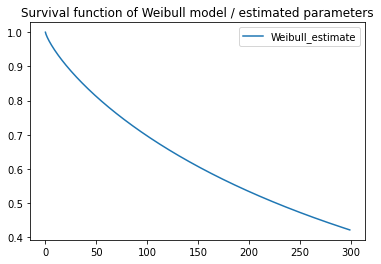

In [11]:
print('Lambda:', wb.lambda_)
print('Rho:', wb.rho_)

ax = wb.survival_function_.plot()
ax.set_title("Survival function of Weibull model / estimated parameters")

$\rho$ is smaller than 1: the event rate (cancer incidence) decreases over time.

### Comparing Several Models

In [12]:
wb = lfl.WeibullFitter().fit(durations=df['tte'], event_observed=df['label'])
exp = lfl.ExponentialFitter().fit(durations=df['tte'], event_observed=df['label'])
log = lfl.LogNormalFitter().fit(durations=df['tte'], event_observed=df['label'])

#### Akaike Information Criterion (AIC)

- Estimates the prediction error and relative quality of statistical models
- The **less information the model loses, the higher its quality**. From `lifelines` documentation: *The model with the lowest AIC is desirable, since it’s a trade off between maximizing the log-likelihood with as few parameters as possible.*

In [13]:
print('Weilbull model:', wb.AIC_)
print('Exponential model:', exp.AIC_)
print('LogNormal model:', log.AIC_)

Weilbull model: 44222.28063808024
Exponential model: 44474.95418984919
LogNormal model: 47666.55189603807


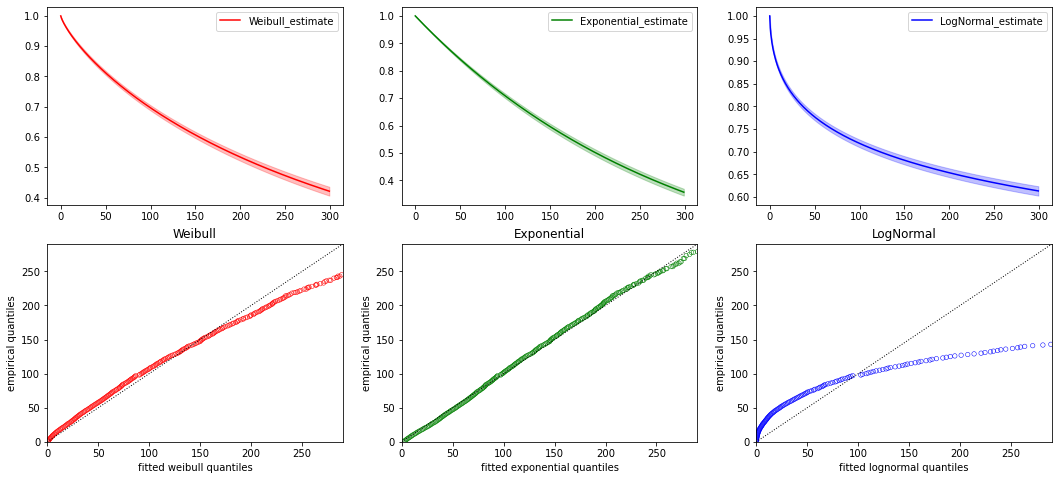

In [14]:
models = {'Weibull':['r', wb], 
          'Exponential':['g', exp], 
          'LogNormal':['b', log]}

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

i = 0
for model_name,model_lst in models.items():
    m_color = model_lst[0]
    model = model_lst[1]
    
    model.plot_survival_function(ax=axes[0,i], c=m_color)
    ax = qq_plot(model, ax=axes[1,i], scatter_color=m_color)
    ax.title.set_text(model_name)
    i += 1

#### Finding the best model based on AIC

In [15]:
best_model, best_aic_ = lfl.utils.find_best_parametric_model(event_times=df['tte'], 
                                                       event_observed=df['label'],
                                                       scoring_method="AIC")
print('Best model:', best_model)
print('Best model AIC:', best_aic_)

Best model: <lifelines.SplineFitter:"SplineFitter: 1 internal knot", fitted with 9966 total observations, 6633 right-censored observations>
Best model AIC: 43659.17156592098


<AxesSubplot:>

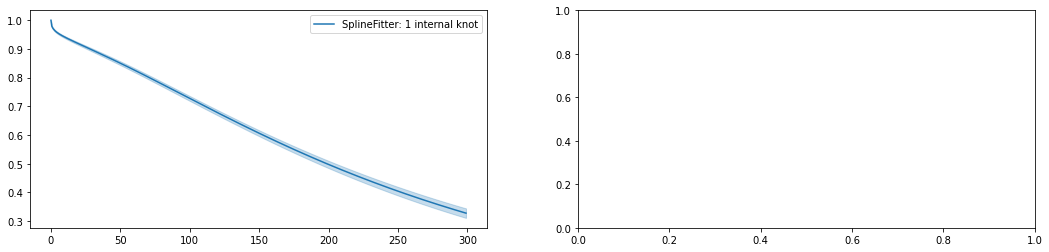

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

best_model.plot_survival_function(ax=axes[0])

# line below raises the error: NotImplementedError: Distribution not implemented in SciPy
#qq_plot(best_model, ax=axes[1])

### Weibul Model and Covariates

In [17]:
aft = lfl.WeibullAFTFitter()
aft.fit(df=df, duration_col='tte', event_col='label')

<lifelines.WeibullAFTFitter: fitted with 9966 total observations, 6633 right-censored observations>

In [18]:
aft.print_summary()

C:\Users\helde\miniconda3\envs\py39\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.WeibullAFTFitter: fitted with 9966 total observations, 6633 right-censored observations>
             duration col = 'tte'
                event col = 'label'
   number of observations = 9966
number of events observed = 3333
           log-likelihood = -21462.69
         time fit was run = 2022-06-10 20:10:14 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                            
lambda_ AGE_DX        -5.74       0.00       0.18            -6.10            -5.39                 0.00                 0.00
        BENBORDCOUNT   1.43       4.18       1.14            -0.81             3.67                 0.45                39.21
        EOD10_SZ      -1.20       0.30       0.11            -1.42            -0.99                 0.24                 0.37
        MALIGCOUNT    -0.96       0.38       0.30            -1.54            -0.37                 0.21                 0.69
        Intercept      8.75    6320.25       0.10             8.55             8.95              5157.63              7744.94
rho_    Intercept     -0.16       0.85       0.01            -0.19            -0.13                 0.83                 0.88

                       cmp to      z      p   -log2(p)
param   covariate                                     
lambda_ AGE_DX           0.00 -31.93 <0.005     740.77
        BENBORDCOUNT     0.00   1.25   0.21       2.25
        EOD10_SZ         0.00 -11.04 <0.005      91.66
        MALIGCOUNT       0.00  -3.22 <0.005       9.60
        Intercept        0.00  84.38 <0.005        inf
rho_    Intercept        0.00 -10.83 <0.005      88.44
---
Concordance = 0.66
AIC = 42937.37
log-likelihood ratio test = 1292.91 on 4 df
-log2(p) of ll-ratio test = 923.30

- $exp(coef)$ shows how much the average survival changes with one unit change in the covariate
- $p$ shows the statistic significance. $p < 0.005$ is significant


#### How the covariates affect the survival function?

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

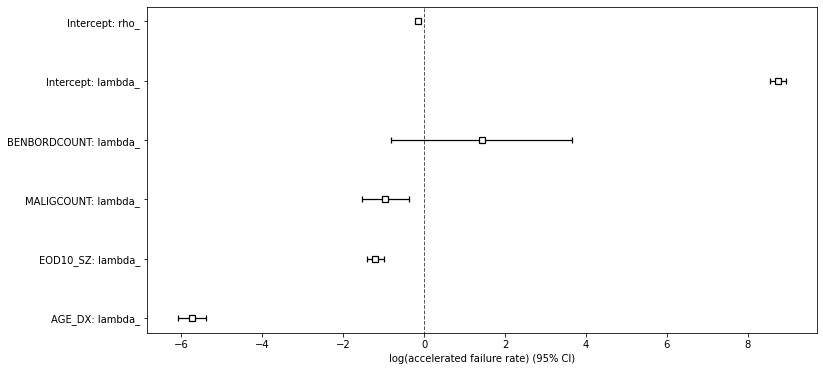

In [19]:
plt.figure(figsize=(12,6))
aft.plot()

#### Evaluating the `MALIGCOUNT` covariate

<AxesSubplot:>

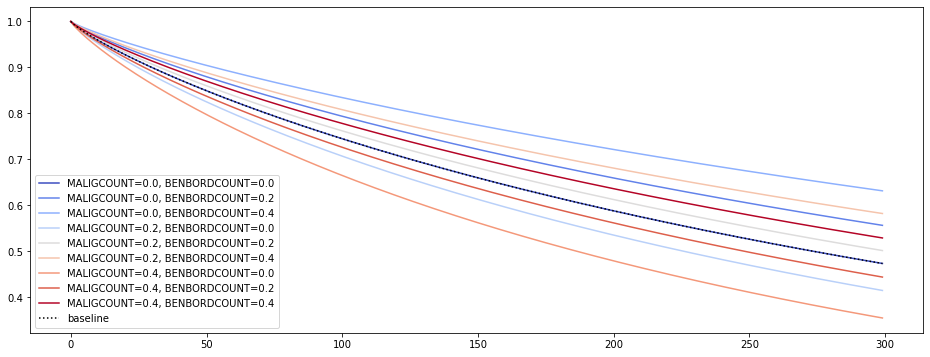

In [20]:
plt.figure(figsize=(16,6))

values = [[x,y] for x in np.arange(0, .51, 0.2) for y in np.arange(0, .51, 0.2)]
aft.plot_partial_effects_on_outcome(covariates=['MALIGCOUNT', 'BENBORDCOUNT'] , cmap='coolwarm', values=values)

<AxesSubplot:>

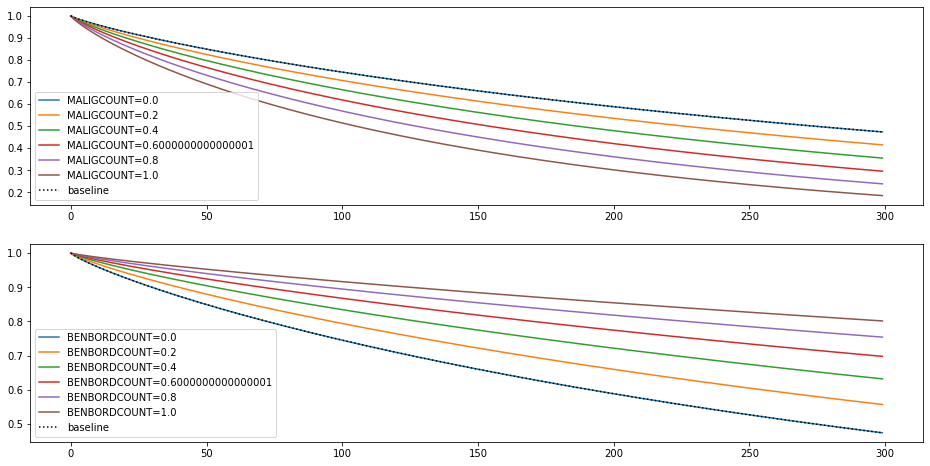

In [21]:
_, axes = plt.subplots(2,1, figsize=(16,8))
aft.plot_partial_effects_on_outcome(covariates='MALIGCOUNT', values=np.arange(0, 1.01, 0.2), ax=axes[0])
aft.plot_partial_effects_on_outcome(covariates='BENBORDCOUNT', values=np.arange(0, 1.01, 0.2), ax=axes[1])

The `baseline` curve is the same one as estimated. The increase of `MALIGCOUNT` (counting of malignant tumors) affects the survival function in such a way that people has cancer sooner.

### Cox Proportional Hazards Model (Cox-PH)

#### Proportional hazards assumption

All the individuals' hazards are proportional:

$$\Large h_A(t) = c \cdot h_B(t) $$

- There is a **baseline hazard** function where other hazards are **scaled**
- The **relative survival impact** of a varaible does not change with time (time-invariant)
- **baseline hazard** the risk for individuals at the baseline levels of covariates, i.e., the averages of covariates

#### Cox-PH model: Regresses covariates on time-to-event/duration.

$$\Large h(t|x) = b_0 \cdot exp\left( \sum^{n}_{i=1} b_i(x_i - \bar{x_i}) \right) $$

- $b_0(t)$: population-level **baseline hazard** function
- $exp(...)$: linear relationship between covariates and the log of hazard. Note: Doesn't depend on time, that's why there is no $t$ in the equation



In [22]:
coxph = lfl.CoxPHFitter()
coxph.fit(df=df, duration_col='tte', event_col='label')

<lifelines.CoxPHFitter: fitted with 9966 total observations, 6633 right-censored observations>

In [23]:
coxph.print_summary()

C:\Users\helde\miniconda3\envs\py39\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 9966 total observations, 6633 right-censored observations>
             duration col = 'tte'
                event col = 'label'
      baseline estimation = breslow
   number of observations = 9966
number of events observed = 3333
   partial log-likelihood = -27481.72
         time fit was run = 2022-06-10 20:10:17 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
AGE_DX         5.35     209.80       0.15             5.05             5.64               156.41               281.40
EOD10_SZ       1.12       3.07       0.09             0.94             1.30                 2.57                 3.68
MALIGCOUNT     0.71       2.04       0.25             0.22             1.21                 1.24                 3.36
BENBORDCOUNT  -1.29       0.28       0.97            -3.19             0.62                 0.04                 1.85

               cmp to     z      p   -log2(p)
covariate                                    
AGE_DX           0.00 35.68 <0.005     924.01
EOD10_SZ         0.00 12.19 <0.005     111.13
MALIGCOUNT       0.00  2.82 <0.005       7.71
BENBORDCOUNT     0.00 -1.33   0.18       2.44
---
Concordance = 0.66
Partial AIC = 54971.44
log-likelihood ratio test = 1467.09 on 4 df
-log2(p) of ll-ratio test = inf

$exp(coef)$ is the **hazard ratio**: how the hazard changes with one unit variation of the covariate.

Example: If `MALIGCOUNT` increases by 1, the hazard function increases by $2.04$, which is 204%!!!

<AxesSubplot:>

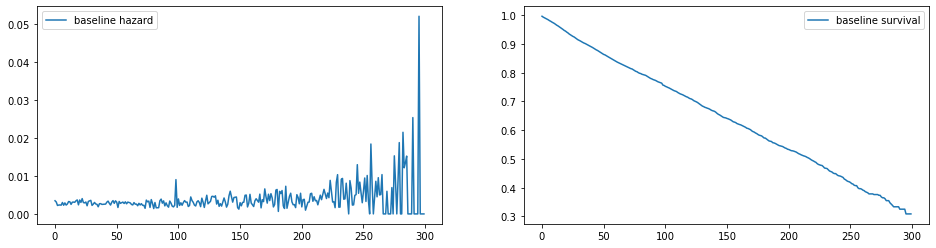

In [24]:
_, axes = plt.subplots(1, 2, figsize=(16,4))

coxph.baseline_hazard_.plot(ax=axes[0])
coxph.baseline_survival_.plot(ax=axes[1])

<AxesSubplot:>

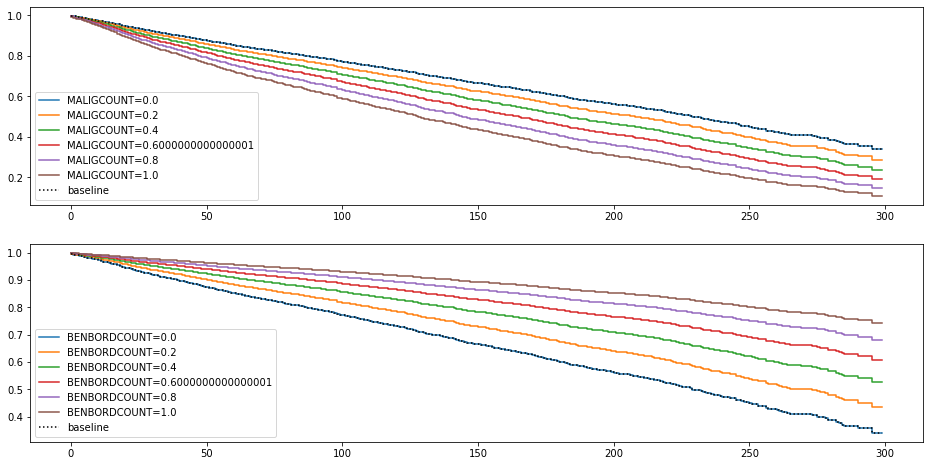

In [25]:
_, axes = plt.subplots(2,1, figsize=(16,8))
coxph.plot_partial_effects_on_outcome(covariates='MALIGCOUNT', values=np.arange(0, 1.01, 0.2), ax=axes[0])
coxph.plot_partial_effects_on_outcome(covariates='BENBORDCOUNT', values=np.arange(0, 1.01, 0.2), ax=axes[1])

#### Checking the Proportional Hazards Assumption

In [26]:
coxph.check_assumptions(df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\helde\miniconda3\envs\py39\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\Users\helde\miniconda3\envs\py39\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 9966 total observations, 6633 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
AGE_DX       km            127.51 <0.005     95.81
             rank          121.91 <0.005     91.74
BENBORDCOUNT km              0.69   0.41      1.30
             rank            0.14   0.71      0.49
EOD10_SZ     km              5.45   0.02      5.67
             rank            6.96   0.01      6.90
MALIGCOUNT   km             14.70 <0.005     12.96
             rank           16.45 <0.005     14.29



1. Variable 'AGE_DX' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'AGE_DX' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'AGE_DX' using pd.cut, and then specify it in
`strata=['AGE_DX', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'EOD10_SZ' failed the non-proportional test: p-value is 0.0083.

   Advice 1: the functional form of the variable 'EOD10_SZ' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.



[]